In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
import cv2
import torch.nn as nn
import torch

img1 = cv2.imread('donald-trump-1.jpg')
img2 = cv2.imread('donald-trump-2.jpg')

#Oriented FAST and Rotated BRIEF
orb = cv2.ORB_create(edgeThreshold=3)

# find the keypoints with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=2)

plt.imshow(img3)
plt.show()

<Figure size 640x480 with 1 Axes>

In [2]:
pts1 = cv2.KeyPoint_convert(kp1)
pts2 = cv2.KeyPoint_convert(kp2)
print(dir(matches[0]))
print(matches[0].trainIdx)
print(matches[0].queryIdx)

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
470
472


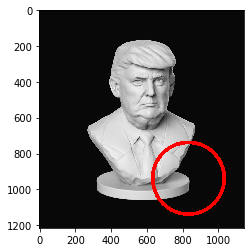

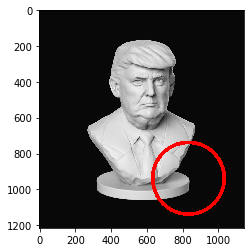

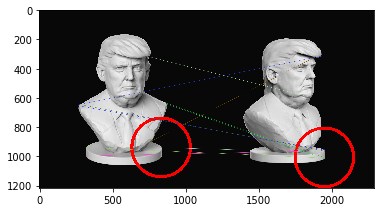

[[838.46454 938.79364]]
[[ 806.21594 1006.8741 ]]


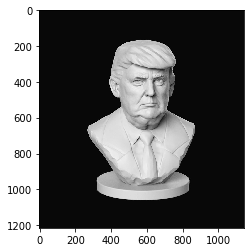

In [3]:
imageA = img1.copy()
imageB = img2.copy()
imageA = cv2.circle(imageA , (835, 938), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
imageB = cv2.circle(imageB , (806, 1006), 200, (255, 0, 0), 20)
plt.imshow(imageA)
plt.show()
img4 = cv2.drawMatches(imageA, kp1, imageB, kp2, matches[:10], None, flags=2)
plt.imshow(img4)
plt.show()
print(cv2.KeyPoint_convert([kp1[matches[0].trainIdx]]))
print(cv2.KeyPoint_convert([kp2[matches[0].queryIdx]]))

plt.imshow(img1)
plt.show()

In [4]:
def transform(a,b):
    #####
    #input shape: [batch, [x, y]]
    #return: list 
    #        shape: [batch, [x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1]]
    #####
    mat = []
    assert(len(a)==len(b))
    for i in range(len(a)):
        x1 = a[i][0]
        y1 = a[i][1]
        x2 = b[i][0]
        y2 = b[i][1]
        mat.append([x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, 1])
    return mat

print(transform(cv2.KeyPoint_convert([kp1[matches[0].trainIdx]]), cv2.KeyPoint_convert([kp2[matches[0].queryIdx]])))    

[[675983.5, 844228.2, 838.46454, 756870.4, 945247.0, 938.79364, 806.21594, 1006.8741, 1]]


In [51]:
import random
import scipy.linalg

class LinearLeastSquaresModel():
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.

    """
    def __init__(self, A, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
        #A shape [batch, m, n]
        self.A = A
        
        #Ax = b , (m * n) * (n * 1) = (m * 1)
        self.b_size = A.shape[1]
        self.b = np.zeros((A.shape[0], self.b_size))
        self.device = device    
        self.criterion = nn.MSELoss()
        
        #value will be assigned after fit, formula Ax = b, where b = [0, 0....]
        self.x = None
        
    def fit(self, data):
        print(self.A)
        x,resids,rank,s = scipy.linalg.lstsq(self.A,self.b)
        self.x = torch.tensor(x).to(self.device)
        print(self.x)
    
    def get_error(self, data):
        batch_size = data.shape[0]
        compute_result = data @ self.x 
#         print(data)
#         print(self.x)
#         print(compute_result)
        err = nn.MSELoss(compute_result, torch.zeros((batch_size, self.b_size)))
        return err.view(batch_size)
    
    def get_x():
        return self.x
    
def RANSAC(data, k, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
    iterations = 0
    best_x = None
    best_err = np.inf
    batches = torch.tensor(data, dtype=torch.float64).to(device)
    batch_size = batches.shape[0]
    while iterations < k:
        maybeinliers = random.sample(data, 8)
        LSmodel = LinearLeastSquaresModel(np.array(maybeinliers) , device = device)
        LSmodel.fit(maybeinliers)
        err = LSmodel.get_error(batches)
        print(err)
        if(err < best_err):
            best_err = err
            best_x = LSmodel.get_x()
    return best_x

In [52]:
a = cv2.KeyPoint_convert([kp1[matches[i].trainIdx] for i in range(len(matches))])
b = cv2.KeyPoint_convert([kp2[matches[i].queryIdx] for i in range(len(matches))])
data = transform(a, b)
RANSAC(data, 10)

[[2.92327875e+05 2.02267266e+05 4.27200012e+02 2.81652969e+05
  1.94881094e+05 4.11600006e+02 6.84288086e+02 4.73472046e+02
  1.00000000e+00]
 [5.08897750e+05 4.52484188e+05 6.80140869e+02 3.14958062e+05
  2.80043562e+05 4.20940857e+02 7.48224060e+02 6.65280090e+02
  1.00000000e+00]
 [3.32000094e+05 1.56459828e+05 5.32500610e+02 4.63869281e+05
  2.18605078e+05 7.44007874e+02 6.23473633e+02 2.93820923e+02
  1.00000000e+00]
 [5.50391562e+05 2.92089000e+05 7.56864075e+02 2.66399562e+05
  1.41376406e+05 3.66336029e+02 7.27200012e+02 3.85920013e+02
  1.00000000e+00]
 [4.75475000e+05 3.16540000e+05 6.65000000e+02 6.66380000e+05
  4.43632000e+05 9.32000000e+02 7.15000000e+02 4.76000000e+02
  1.00000000e+00]
 [5.48674688e+05 2.50822719e+05 7.50000000e+02 2.97747469e+05
  1.36113125e+05 4.07000000e+02 7.31566284e+02 3.34430298e+02
  1.00000000e+00]
 [5.37477250e+05 2.91133531e+05 7.50000000e+02 2.24450516e+05
  1.21577367e+05 3.13200012e+02 7.16636353e+02 3.88178040e+02
  1.00000000e+00]
 [3.34

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
# def sift_feature(image, device = 'cuda' if torch.cuda.is_available() else 'cpu'):
#     print("image shape:",image.shape, )
#     h,w = image.shape
#     patch_size = min([h,w])
#     patch = image[:patch_size, :patch_size]#image[h//4: h//4 + patch_size,w//3 : w//3 + patch_size]
#     # It takes n_patches x 1 x patch_size x patch_size input == standard pytorch batch format
#     patches = np.ndarray((1, 1, patch_size, patch_size), dtype=np.float32)
#     patches[0,0,:,:] = patch
        
#     SIFT = SIFTNet(patch_size = patch_size).to(device)
#     SIFT.eval()
    
#     t = time.time()
#     with torch.no_grad():       
#         torch_patches = torch.from_numpy(patches).cuda()
#         res = SIFT(torch_patches)
#         print(res)
#         sift = np.round(512. * res.data.cpu().numpy()).astype(np.int32)

#     print ('device:',device)
#     print(' time', time.time() - t)   
#     plt.figure()
#     plt.imshow(patch, cmap="gray")
#     return sift